<H1> AudioExample </H1> <br> 
 Gin up method for looking at accelerometer data using standard usb audio port.  <br> 
 Original exploration. 
<hr> 
<H2>Modification history </H2>
<table>
    <tr>
        <th> Modified </th>
        <th> BY </th>
        <th> Reason </th>
    </tr>
    <tr>
        <td> 18-Feb-25</td>
        <td> CBL </td>
        <td> Original </td>
    </tr>
    <tr>
        <td> 24-Mar-25</td>
        <td> CBL </td>
        <td> Added in drive capability, drive the Modal 2000E device </td>
    </tr>
    <tr>
        <td> 19-May-25</td>
        <td> CBL </td>
        <td> Play Riken Data </td>
    </tr>
</table>

<hr> 
<H2> References </H2> 
<a href="https://people.csail.mit.edu/hubert/pyaudio/docs/">  Documentation </a> <br> 
<a href="https://stackoverflow.com/questions/40704026/voice-recording-using-pyaudio"> example recording</a> <br> 
<a href="https://github.com/jleb/pyaudio/blob/master/test/record.py"> example 2 </a><br> 
<a href="https://stackoverflow.com/questions/4623572/how-do-i-get-a-list-of-my-devices-audio-sample-rates-using-pyaudio-or-portaudio"> Get Sound device properties. </a><br> 
<a href="https://python-sounddevice.readthedocs.io/en/0.5.1/installation.html"> Sounddevice documentation</a>
<H2> Pre-requisites</H2> 
numpy<br>
matplotlib<br>
pyaudio<br>
scipy<br>
sounddevice - which returns data in numpy arrays!<br> 
<H3> Modal 2000E information</H3>
<a href="https://www.modalshop.com/vibration-test/products/vibration-test-shakers/2-lbf-mini-inertial-shaker"> Modal 2000E</a> <br> 
Force rating 9N <br> 
Max Frequency 3000Hz <br> 
Max stroke 8.9mm <br> 
Shaker Model: 2002E <br> 
Input voltage to Drive Amplifier: 0-1 V<br> 
<hr>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as konst
import pyaudio
import wave
import sounddevice as sd
import scipy  as sp

In [2]:
def RecordInput(DeviceIndex, RECORD_SECONDS=1):
    """
    input data using pyaudio
    @param DeviceIndex - index to actual device based on ShowDevices. 
    This returns a length of sample frames, not quite what I want. 
    """
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 1024          # Don't need so many samples/second for what we intend to do. 
    WAVE_OUTPUT_FILENAME = "output.wav"

    p = pyaudio.PyAudio()
    devinfo = p.get_device_info_by_index(DeviceIndex)  # Or whatever device you care about.
    print("Devinfo: ", devinfo)

    stream = p.open(format=FORMAT,
                          channels = devinfo['maxInputChannels'],
                          rate     = RATE,
                          input    = True,
                          input_device_index=DeviceIndex,
                          frames_per_buffer=CHUNK)

    print("* recording")

    frames = []
    TotalFrames = int(RATE / CHUNK * RECORD_SECONDS)
    print(' Total frames: ', TotalFrames)
    for i in range(0, TotalFrames):
        data = stream.read(CHUNK)
        frames.append(data)

    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()
    # Convert byte array to NumPy array
    audio_data_bytes = b''.join(frames)  # Concatenate all frames
    audio_array = np.frombuffer(audio_data_bytes, dtype=np.int16)
    return audio_array

In [2]:
def PlayWav(filename):
    CHUNK = 1024

    with wave.open(filename, 'rb') as wf:
        # Instantiate PyAudio and initialize PortAudio system resources (1)
        p = pyaudio.PyAudio()

        # Open stream (2)
        stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                        channels=wf.getnchannels(),
                        rate=wf.getframerate(),
                        output=True)

        # Play samples from the wave file (3)
        while len(data := wf.readframes(CHUNK)):  # Requires Python 3.8+ for :=
            stream.write(data)

        # Close stream (4)
        stream.close()

        # Release PortAudio system resources (5)
        p.terminate()
        

In [3]:
def ConvertWaveform(yin):
    """
    @param yin - mono input, analog values {0:1}
    @return vector of L,R alternating pairs. Same output on both. Assume 16 bit resolution as output. 
    """
    y  = yin * 65535          # make 16 bit max value. 
    IY = y.astype(np.int16) # convert to integer
    # allocate output array
    N = len(IY)
    rv = np.zeros(2*N+1, dtype=np.int16)
    for i in range(0,N):
        rv[2*i] = IY[i]
        rv[2*i+1] = IY[i]
    return rv

In [17]:
def PlayWaveform(DeviceIndex, Waveform, SampleRate):
    """
    @brief - Play provided waveform to device, ostensibly the shaker
    @param DeviceIndex - choose output device
    @param Waveform - waveform to play. 
    """
    print("Play waveform, SampleRate:", SampleRate)
    # Instantiate PyAudio and initialize PortAudio system resources (1)
    p = pyaudio.PyAudio()
    devinfo = p.get_device_info_by_index(DeviceIndex)  # Or whatever device you care about.
    print("Devinfo: ", devinfo)

    # Open stream (2)
    stream = p.open(format=p.get_format_from_width(2),
                    channels=2,                       # assume a stereo output
                    rate=SampleRate,
                    output_device_index = DeviceIndex,
                    output=True)

    # Play samples from the wave file (3)
    stream.write(Waveform)

    # Close stream (4)
    stream.close()

    # Release PortAudio system resources (5)
    p.terminate()


In [15]:
def ShowDevices():
    p = pyaudio.PyAudio()
    info = p.get_host_api_info_by_index(0)
    numdevices = info.get('deviceCount')

    print('Number of devices: ', numdevices)

    for i in range(0, numdevices):
        in_channels = p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')
        out_channels = p.get_device_info_by_host_api_device_index(0, i).get('maxOutputChannels')
        print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'), " inputs: ", in_channels,
             " outputs: ", out_channels)


In [7]:
def PlotWelch(yin, norm=1.0, SampleRate=1024):
    # Try this welch method.
    N = len(yin)
    NFrames = N/SampleRate
    print("Welch:", N, ' NFrames = ', NFrames)
    # returns a vector of frequencies used by fft, inputs are sample rate and 1/sample rate. 
    freq  = np.fft.fftfreq(SampleRate, 1.0/SampleRate)
    # power spectrum, via scipy welch. 'boxcar' means no window, nperseg=len(y) so that fft computed on the whole signal.
    freq2,power2=sp.signal.welch(yin, 
                                 fs = SampleRate,        # Sampling rate
                                 window  = 'hamming',
                                 nperseg = SampleRate,   # length of each segment
                                 scaling = 'spectrum', 
                                 axis=-1, 
                                 average='mean')
    # Normalization 
    p = np.sqrt(power2/norm)
    # OVERRIDE for plotting if desired. 
    #N = 100
    # plot supresses DC component. 
    plt.semilogy(freq2[1:N],p[1:N])
    #plt.xlim(0,np.max(freq[0:NP]))
    plt.grid()
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (m/s^2)") 
    #plt.ylim((LowerLimit, UpperLimit))
    plt.title('FFT')

In [108]:
# Lets hear what the accelerometer sounds like. 
Path     = '/Users/clirakis/Documents/Acc/Basque/Vibration_test_raw_data_2025-02-12_1444/'
Filename  = 'VM_001_20250110_191000_0108_0000_ST0007.wav'
Filespec  = Path + Filename
#PlayWav(Filespec) # Can't do this unless we restructure the input --- 3 channels!!

In [9]:
# Riken Data Path 
FilePath = '/Users/clirakis/Documents/Acc/Riken/RIKEN-Boltdown-FridgeRunning-2/'
FileName = 'Accel_2025-05-13T11-56-22-680.wdd'    # This is kind of a baseline. 
#FileName = 'Accel_2025-05-13T13-56-22-972.wdd'    # a blip in the first 500 seconds
#FileName = 'Accel_2025-05-13T14-56-23-115.wdd'    # Starts to get noisy at 1000 seconds
#FileName = 'Accel_2025-05-13T15-56-23-292.wdd'    # Pretty much noisy the whole way through .
#FileName = 'Accel_2025-05-13T16-56-23-440.wdd'    # about 30dB above baseline. 
Filespec = FilePath + FileName
# Start log file for read. 
log_fd = open("WebDAQ.log", 'w', encoding='utf-8')
wd = WebDAQ704(Filespec, log_fd)
z = ReadBlock(wd)   # z axis only. 
wd.Close()
# Play the waveform. 
DeviceIndex = 2
SampleRate = 2048
PlayWaveform(DeviceIndex, z, SampleRate)

NameError: name 'WebDAQ704' is not defined

In [21]:
ShowDevices()

Number of devices:  5
Input Device id  0  -  Cable Creation  inputs:  1  outputs:  2
Input Device id  1  -  MacBook Pro Microphone  inputs:  1  outputs:  0
Input Device id  2  -  MacBook Pro Speakers  inputs:  0  outputs:  2
Input Device id  3  -  Microsoft Teams Audio  inputs:  1  outputs:  1
Input Device id  4  -  ZoomAudioDevice  inputs:  2  outputs:  2


In [7]:
Y = RecordInput(1,2)

Devinfo:  {'index': 1, 'structVersion': 2, 'name': 'Cable Creation', 'hostApi': 0, 'maxInputChannels': 1, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.0038541666666666668, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.0131875, 'defaultSampleRate': 48000.0}
* recording
 Total frames:  2
* done recording


In [25]:
#
# Make a waveform
# 
F0 = 400  # Hz
W  = 2.0 * konst.pi*F0
SampleRate = 48000
NSeconds = 5*60
t = np.arange(0,NSeconds*SampleRate)/SampleRate
y = 0.25*(1.0 + np.sin(W*t))
#plt.plot(y)
#PlotWelch(y, 1.0, SampleRate)
# turn into a short
# Scale to short
#plt.plot(IY[:400])

In [26]:
IY = ConvertWaveform(y)
#plt.plot(IY[0:400])
# Mac speakers 4
# 
PlayWaveform(0, IY, SampleRate)

Play waveform, SampleRate: 48000
Devinfo:  {'index': 0, 'structVersion': 2, 'name': 'Cable Creation', 'hostApi': 0, 'maxInputChannels': 1, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.0038541666666666668, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.0131875, 'defaultSampleRate': 48000.0}


In [35]:
PlayWaveform(1, IY, SampleRate)

Play waveform, SampleRate: 48000
Devinfo:  {'index': 1, 'structVersion': 2, 'name': 'Cable Creation', 'hostApi': 0, 'maxInputChannels': 1, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.0038541666666666668, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.0131875, 'defaultSampleRate': 48000.0}


2048 2048


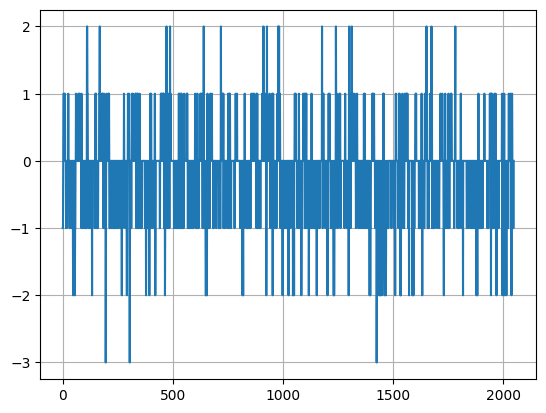

In [9]:
X = np.arange(len(Y))
print(len(Y), len(X))
plt.plot(Y)
plt.grid()

Welch: 2048  NFrames =  2.0


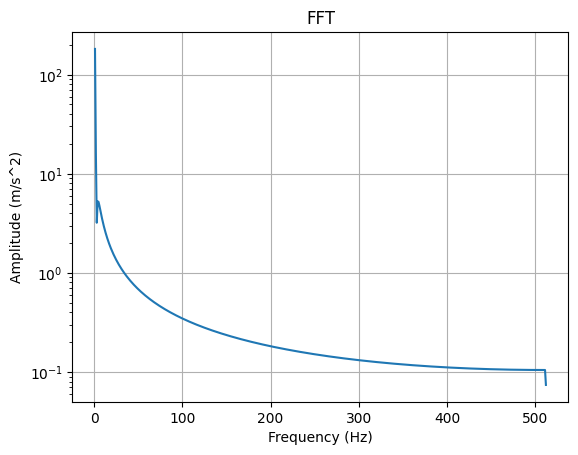

In [10]:
PlotWelch(X)

In [43]:
def ScanRates(device):
    """
    Using sounddevice
    @param device - integer index to device
    """
    samplerates = 16000,32000, 44100, 48000, 96000, 128000

    supported_samplerates = []
    for fs in samplerates:
        try:
            sd.check_output_settings(device=device, samplerate=fs)
        except Exception as e:
            print('Exception: ',fs, e)
        else:
            supported_samplerates.append(fs)
    print(supported_samplerates)


In [11]:
def CheckInfo(DeviceIndex=1):
    """
    pyaudio version
    @param DeviceIndex - index into which device we should select. 
    pyaudio version. 
    """
    # sample rates we want to check. 
    samplerates = 1024, 2048, 4096, 8192, 16000,32000, 44100, 48000, 96000, 128000
    
    supported_samplerates = []
   
    p = pyaudio.PyAudio()
    devinfo = p.get_device_info_by_index(DeviceIndex)  # Or whatever device you care about.
    print("Devinfo: ", devinfo)
    #
    # The macbook documentation says that the internal ADC can only support
    # 
    for fs in samplerates:
        if p.is_format_supported( fs,  # Sample rate
                                 input_device=devinfo['index'],
                                 input_channels=devinfo['maxInputChannels'],
                                 input_format=pyaudio.paInt16):
            supported_samplerates.append(fs)

    print(supported_samplerates)


In [12]:
CheckInfo(1)

Devinfo:  {'index': 1, 'structVersion': 2, 'name': 'Cable Creation', 'hostApi': 0, 'maxInputChannels': 1, 'maxOutputChannels': 2, 'defaultLowInputLatency': 0.01, 'defaultLowOutputLatency': 0.0038541666666666668, 'defaultHighInputLatency': 0.1, 'defaultHighOutputLatency': 0.0131875, 'defaultSampleRate': 48000.0}
[1024, 2048, 4096, 8192, 16000, 32000, 44100, 48000, 96000, 128000]
